[View in Colaboratory](https://colab.research.google.com/github/redcican/Generatvie-Adversarial-Networks-/blob/master/02_AC_GAN_with_Keras.ipynb)

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from keras.layers import Input, Reshape, Flatten, multiply
from keras.models import Model, Sequential
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import fashion_mnist
from keras.optimizers import Adam
from keras import initializers
from scipy.interpolate import interp1d

Using TensorFlow backend.


In [0]:
np.random.seed(10)
random_dim = 100

In [0]:
# classes dictionary
label_dict = {0: 'tshirt',
             1: 'trouser',
             2: 'pullover',
             3: 'dress',
             4: 'coat',
             5: 'sandal',
             6: 'shirt',
             7: 'sneaker',
             8: 'bag',
             9: 'boot'}

In [0]:
def load_minst_data():
    # load the data
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    # normalize our inputs to be in the range[-1, 1] 
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert x_train with a shape of (60000, 28, 28) to (60000, 784) so we have
    # 784 columns per row
    return (x_train, y_train, x_test, y_test)

In [7]:
x_train, y_train, x_test, y_test = load_minst_data()
print("x_train shape: {}".format(x_train.shape))
print("y_train.shape:{}".format(y_train.shape))

4423680/4422102 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28)
y_train.shape:(60000,)


In [8]:
print(type(x_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [0]:
input_classes =pd.Series(y_train).nunique()
#input dimensions
input_rows = 28
input_cols = 28
input_channels = 1

In [0]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import numpy as np

class ACGAN():
    def __init__(self, input_rows, input_cols, input_channels, input_classes, latent_dim=100):
        # Input shape
        self.img_rows = input_rows
        self.img_cols = input_cols
        self.channels = input_channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.num_classes = input_classes
        self.latent_dim = latent_dim

        optimizer = Adam(0.0002, 0.5)
        losses = ['binary_crossentropy', 'sparse_categorical_crossentropy']

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=losses,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise and the target label as input
        # and generates the corresponding digit of that label
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        img = self.generator([noise, label])

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated image as input and determines validity
        # and the label of that image
        valid, target_label = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model([noise, label], [valid, target_label])
        self.combined.compile(loss=losses,
            optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(self.channels, kernel_size=3, padding='same'))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, 100)(label))

        model_input = multiply([noise, label_embedding])
        img = model(model_input)

        return Model([noise, label], img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.summary()

        img = Input(shape=self.img_shape)

        # Extract feature representation
        features = model(img)

        # Determine validity and label of the image
        validity = Dense(1, activation="sigmoid")(features)
        label = Dense(self.num_classes+1, activation="softmax")(features)

        return Model(img, [validity, label])

    def train(self, x_train, y_train, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        #(X_train, y_train), (_, _) = mnist.load_data()
        #X_train, y_train = self.X_train, self.y_train

        # Configure inputs
        #X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        x_train = np.expand_dims(x_train, axis=3)
        y_train = y_train.reshape(-1, 1)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        # Loss output
        g_loss_epochs = np.zeros((epochs, 1))
        d_loss_epochs = np.zeros((epochs, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            imgs = x_train[idx]

            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, 100))

            # The labels of the digits that the generator tries to create an
            # image representation of
            sampled_labels = np.random.randint(0, 10, (batch_size, 1))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict([noise, sampled_labels])

            # Image labels. 0-9 if image is valid or 10 if it is generated (fake)
            img_labels = y_train[idx]
            fake_labels = 10 * np.ones(img_labels.shape)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, [valid, img_labels])
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, [fake, fake_labels])
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], [valid, sampled_labels])

            #show the final losses
            g_loss_epochs[epoch] = g_loss[0]
            d_loss_epochs[epoch] = d_loss[0]

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                # Plot the progress
                print ("Epoch: %d [D loss: %f, acc.: %.2f%%, op_acc: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[3], 100*d_loss[4], g_loss[0]))
                #do not save model
                #self.save_model()
                self.sample_images(epoch, smp_rows=2, smp_cols=10, save_img=False)

        return g_loss_epochs, d_loss_epochs
 

    #row, cols to be sampled
    def sample_images(self, epoch, smp_rows=5, smp_cols=10, save_img=True, fig_size=(8, 3)):
        r, c = smp_rows, smp_cols
        noise = np.random.normal(0, 1, (r * c, 100))
        sampled_labels = np.array([num for _ in range(r) for num in range(c)])
        gen_imgs = self.generator.predict([noise, sampled_labels])
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        #plt.figure(figsize=fig_size)
        fig, axs = plt.subplots(r, c, figsize=fig_size)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt,:,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        if save_img:
            fig.savefig("../images/%d.png" % epoch)
        else:
            #plt.figure(figsize=fig_size)
            plt.show()
        plt.close()

    def sample_single_image(self, noise, label):
        gen_imgs = self.generator.predict([noise, np.array(label).reshape((1, ))])
        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        plt.imshow(gen_imgs[0, :, :, 0], cmap='gray')

    def save_model(self):

        def save(model, model_name):
            model_path = "../saved_model/%s.json" % model_name
            weights_path = "../saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            #
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "generator")
        save(self.discriminator, "discriminator")

In [11]:
fahsion_acgan = ACGAN(input_rows, input_cols, input_channels, input_classes)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          4640      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 32)          0         
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 32)          0         
__________

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch: 0 [D loss: 3.202901, acc.: 43.00%, op_acc: 14.00%] [G loss: 3.572057]


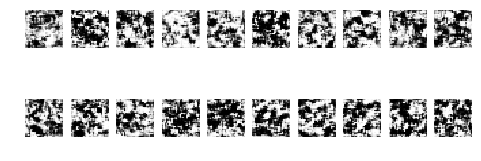

Epoch: 200 [D loss: 1.986397, acc.: 44.00%, op_acc: 51.00%] [G loss: 2.384652]


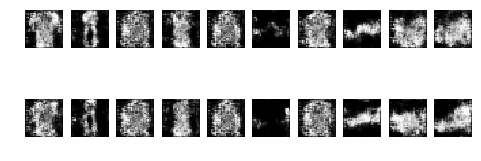

Epoch: 400 [D loss: 2.026356, acc.: 44.00%, op_acc: 40.00%] [G loss: 1.865502]


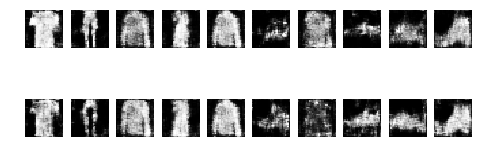

Epoch: 600 [D loss: 1.894308, acc.: 55.50%, op_acc: 40.00%] [G loss: 1.843651]


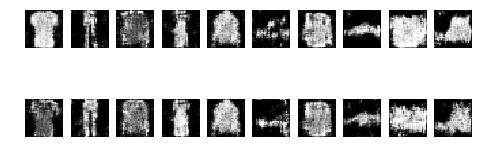

Epoch: 800 [D loss: 1.936622, acc.: 55.50%, op_acc: 39.00%] [G loss: 1.942179]


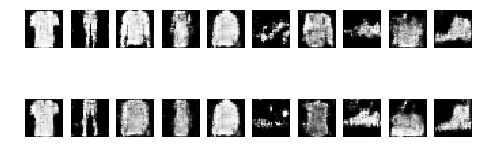

Epoch: 1000 [D loss: 1.768706, acc.: 51.50%, op_acc: 44.00%] [G loss: 1.894440]


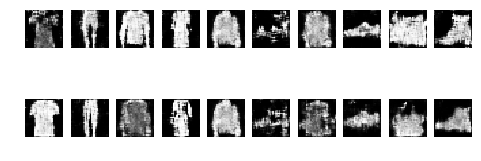

Epoch: 1200 [D loss: 1.846261, acc.: 51.00%, op_acc: 39.50%] [G loss: 1.876223]


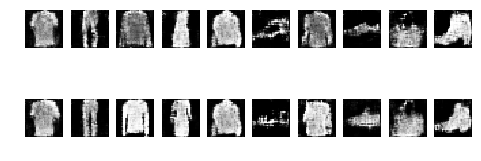

Epoch: 1400 [D loss: 1.787294, acc.: 50.50%, op_acc: 38.50%] [G loss: 1.660487]


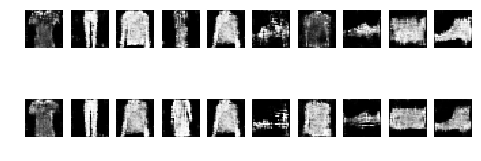

Epoch: 1600 [D loss: 1.824088, acc.: 46.50%, op_acc: 37.50%] [G loss: 1.806428]


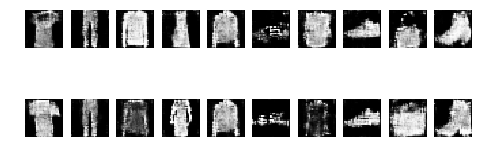

Epoch: 1800 [D loss: 1.809535, acc.: 48.50%, op_acc: 39.50%] [G loss: 1.775404]


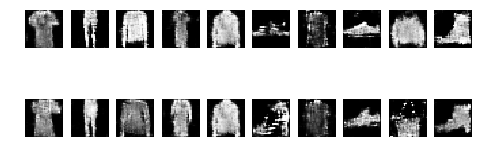

Epoch: 2000 [D loss: 1.787595, acc.: 52.50%, op_acc: 40.50%] [G loss: 1.772474]


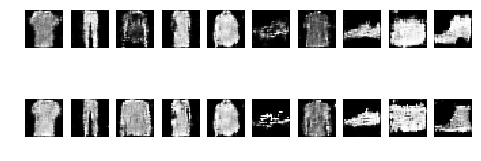

Epoch: 2200 [D loss: 1.853096, acc.: 43.00%, op_acc: 38.50%] [G loss: 1.773014]


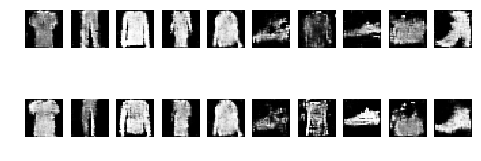

Epoch: 2400 [D loss: 1.651963, acc.: 50.50%, op_acc: 50.00%] [G loss: 1.823252]


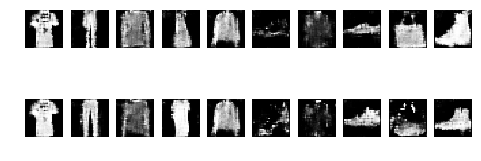

Epoch: 2600 [D loss: 1.730287, acc.: 54.50%, op_acc: 39.50%] [G loss: 1.758897]


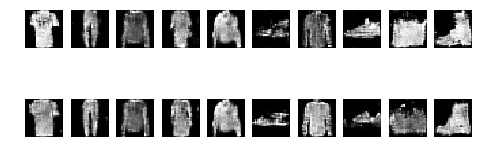

Epoch: 2800 [D loss: 1.721756, acc.: 45.50%, op_acc: 40.50%] [G loss: 1.698028]


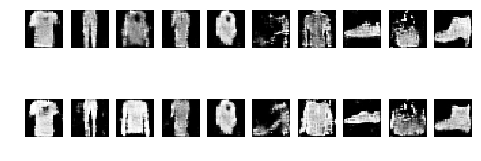

In [12]:
# Train the AC-GAN with the fashion-mnist data
g_loss, d_loss = fahsion_acgan.train(x_train,y_train, epochs=3000, batch_size=100,sample_interval=200)

In [0]:
def plot_gan_losses(g_loss, d_loss):
    plt.plot(g_loss)
    plt.plot(d_loss)
    plt.title('GAN Loss Evaluation')
    plt.ylabel('')
    plt.xlabel('epoch')
    plt.legend(['Generator', 'Discriminator'],loc='upper right')
    plt.show()

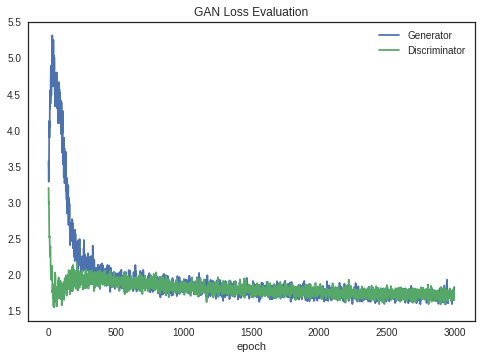

In [14]:
plt.style.use('seaborn-white')
plot_gan_losses(g_loss, d_loss)

It can be seen that in the first epochs (first 200) the generator has huge loss values, while the discriminator has lower loss values, meaning that the generator is not being able to trick the discriminator yet. The loss for the generator decreases after some epochs, arriving to a stable point after epoch 700.

#### sample images from the final trained AC-GAN

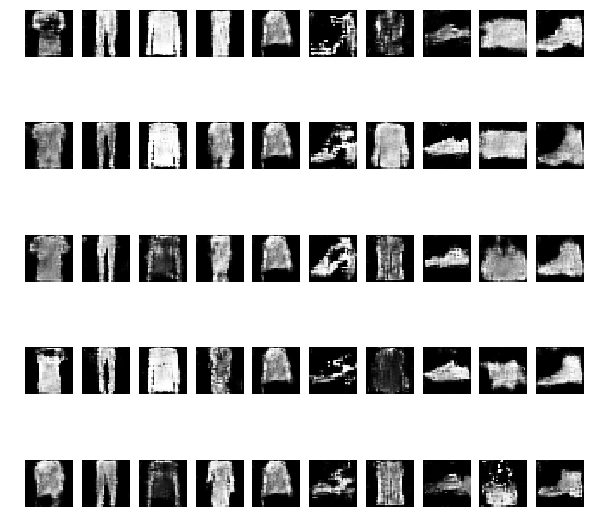

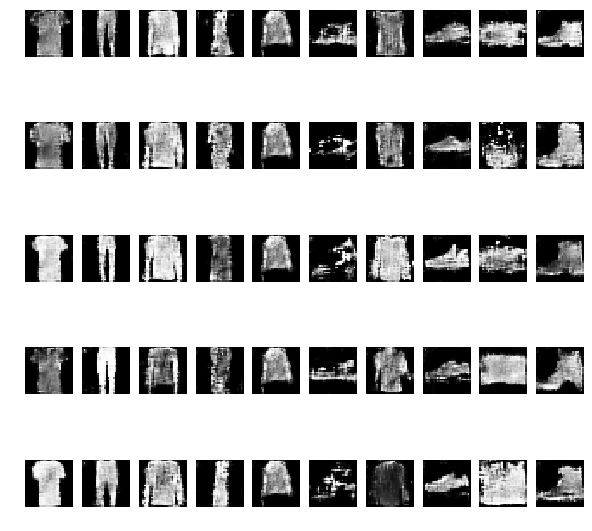

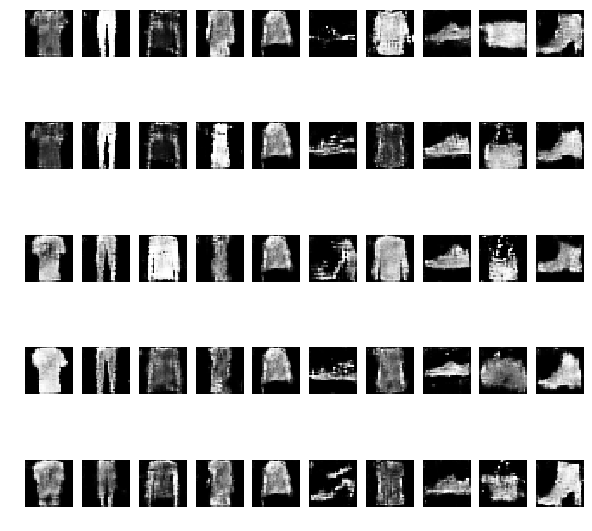

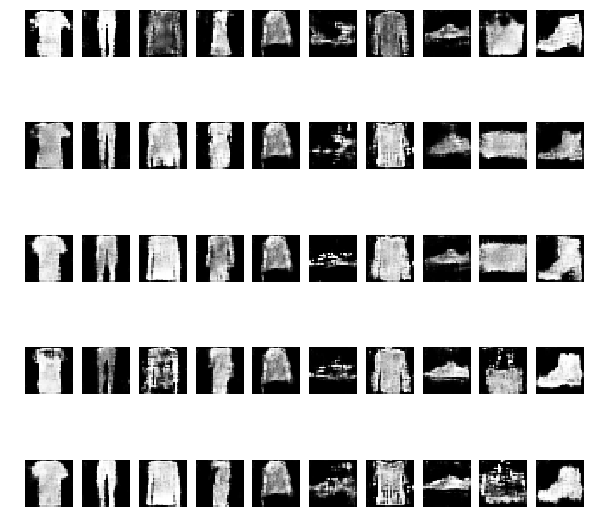

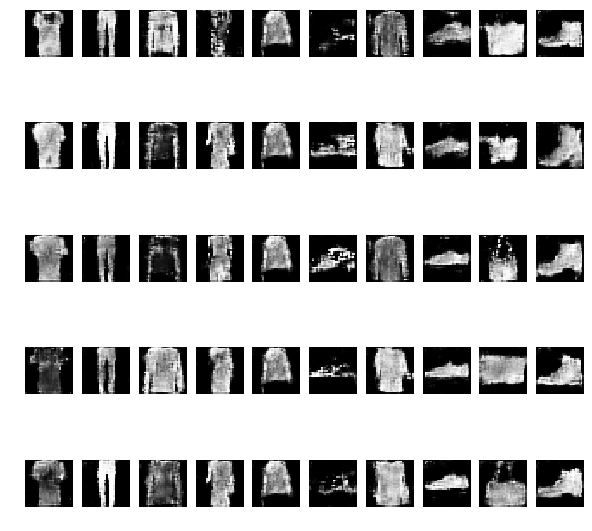

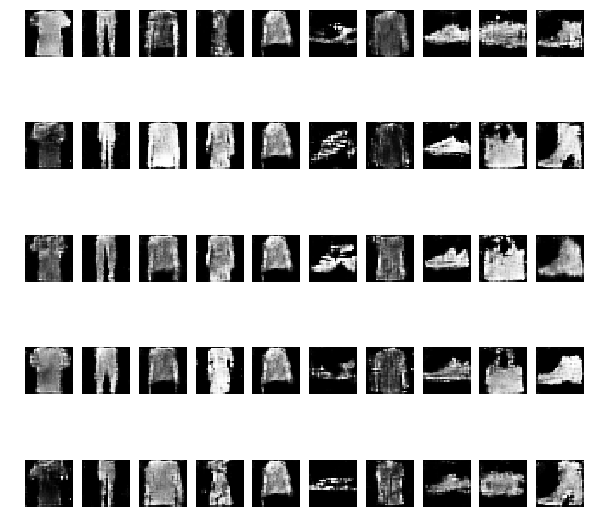

In [16]:
for i in range(3000):
    if i % 500 == 0:
        fahsion_acgan.sample_images(i, smp_rows=5, smp_cols=10, save_img=False,fig_size=(10,10))

Most classes we get interesting outputs, while for the 6th column (sandals) we get not so nice generated images. In the good side, it can also be seen intra-class variability, which is a good sign that the ac-gan is performing well